# [Ateliers: Technologies des grosses data](https://github.com/wikistat/Ateliers-Big-Data)

# [Reconnaissance d'Activité Humaine](https://github.com/wikistat/Ateliers-Big-Data/5-HumanActivityRecognition) ([*HAR*](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)) en <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a>  avec <a href="https://keras.io/"><img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" style="max-width: 100px; display: inline" alt="Keras"/></a>
##  Seconde partie:  étude des signaux bruts

##  Introduction
###  Contexte
Les données sont issues de la communauté qui vise la reconnaissance d'activités humaines (*Human activity recognition, HAR*) à partir d’enregistrements, par exemple du gyroscope et de l'accéléromètre d'un smartphone, objet connecté précurseur et dont la fonctionnalité de téléphonie devient très secondaire.
Voir à ce propos l'[article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) relatant un colloque de 2013.  

Les données publiques disponibles et largement étudiées ont été acquises, décrites et analysées par [Anguita et al. (2013)]().
Elles sont accessibles sur le [dépôt](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) de l'University California Irvine (UCI) consacré à l'apprentissage machine ainsi que sur le site *Kaggle*.

L'archive contient les données brutes: accélérations en x, y, et z, chacun de 128 colonnes. D'autres fichiers en y soustrayant la gravité naturelle ainsi que les accélérations angulaires en x, y, et z soit en tout 9 fichiers. Mais 6 utiles avec 6*128=768 mesures.

C'est sur ces données bruts que nous allons appliquer des méthodes d'apprentissage

### 1.2 Objectifs
Cette deuxième étape s'intéresse aux données brutes. Est-il possible d'économiser le travail préliminaire de définition des variables métier en utilisant par exemple les ressources de décompositions systématiques sur une base d'ondelette ou un algorihtme d'apprentissage profond?

### 1.3 Travail à réaliser

- Affichage des données "Brutes"
- Modélisation, prévision de l'échantillon test par
   - scikit-learn
       - SVC
   - Keras
       - MLP sur signaux "applatis"
       - MLP sur signaux mutlidimensionelles
       - LSTM
       - 1D Convolution
       - 2D Convolution
   
- Ajouter à ce calepin: 
    - optimisation des paramètres des différentes méthodes
    - Application de ces méthodes sur après décombosition des signaux en ondelettes

## Librairies

In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import random
import itertools

#Utils Sklearn
import sklearn.svm as ssvm
from sklearn.metrics import confusion_matrix

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()

# DEEP LEARING
import tensorflow as tf
np.random.seed(42)
tf.set_random_seed(42)

# for reproducibility
# https://github.com/fchollet/keras/issues/2280
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import keras.models as km 
import keras.layers as kl 
import keras.layers.core as klc

## Load Data

Les données sont celles originales du dépôt de l'[UCI](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Elle peuvent être téléchargées en cliquant [ici](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip).

On crée deux jeux d'apprentissages et deux jeux de test différent, sont stucturés en deux dimension différentes : 

    1/ Multidimensionel : Un individus est constitué de 9 Séries Temporelles
        * Dimension (N, 128, 9)
    2/ Unidimensionnel : Les 9 Séries Temporelles sont concaténé pour consituer un vecteur de 128*9 = 1152 features
        * Dimension (N, 11152)
        
On crée également deux structures différentes pour la variable de réponse car les librairies scikit-learn et Keras prennent en compte des structure différente : 
    
    1/ Scikit-Learn :  Un vecteur de taille (N, 1) ou pour chaque individu on indique le numéro du label (de 1 à 5)
    2/ Keras : Une matrice de taille (N, 6) ou pour chaque individu la colonne qui représente son label est à 1, et 0 sinon.

In [2]:
DATADIR_UCI = '/Users/bguillouet/Insa/DeepLearning/data/HARWS//UCI HAR Dataset'

SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]

def my_read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signal(data_dir, subset, signal):
    filename = f'{data_dir}/{subset}/Inertial Signals/{signal}_{subset}.txt'
    x = my_read_csv(filename).as_matrix()
    return x 

def load_signals(data_dir, subset, flatten = False):
    signals_data = []
    for signal in SIGNALS:
        signals_data.append(load_signal(data_dir, subset, signal)) 
    
    if flatten :
        X = np.hstack(signals_data)
    else:
        X = np.transpose(signals_data, (1, 2, 0))
        
    return X 

def load_y(data_dir, subset, dummies = False):
    filename = f'{data_dir}/{subset}/y_{subset}.txt'
    y = my_read_csv(filename)[0]
    
    
    if dummies:
        Y = pd.get_dummies(y).as_matrix()
    else:
        Y = y.as_matrix()
    
    return Y


#Multidimensional Data
X_train, X_test = load_signals(DATADIR_UCI, 'train'), load_signals(DATADIR_UCI, 'test')
# Flattened Data
X_train_flatten, X_test_flatten = load_signals(DATADIR_UCI, 'train', flatten=True), load_signals(DATADIR_UCI, 'test', flatten=True)

# Label Y
Y_train_label, Y_test_label = load_y(DATADIR_UCI, 'train', dummies = False), load_y(DATADIR_UCI, 'test', dummies = False)
#Dummies Y (For Keras)
Y_train_dummies, Y_test_dummies = load_y(DATADIR_UCI, 'train', dummies = True), load_y(DATADIR_UCI, 'test', dummies = True)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

In [3]:
print("Dimension")
print("Données Multidimensionelles, : " + str(X_train.shape))
print("Données Unimensionelles, : " + str(X_train_flatten.shape))
print("Vecteur réponse (scikit-learn) : " + str(Y_train_label.shape))
print("Matrice réponse(Keras) : " + str(Y_train_dummies.shape))

Dimension
Données Multidimensionelles, : (7352, 128, 9)
Données Unimensionelles, : (7352, 1152)
Vecteur réponse (scikit-learn) : (7352,)
Matrice réponse(Keras) : (7352, 6)


## Affichage des données

In [4]:
CMAP = plt.get_cmap("Accent")
SIGNALS = ["body_acc x", "body_acc y", "body_acc z", 
                "body_gyro x", "body_gyro y", "body_gyro z", 
               "total_acc x", "total_acc y", "total_acc z"] 


ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LAYING"}

def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(act-1))

            
def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(act-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

### Tous les signaux

<IPython.core.display.Javascript object>


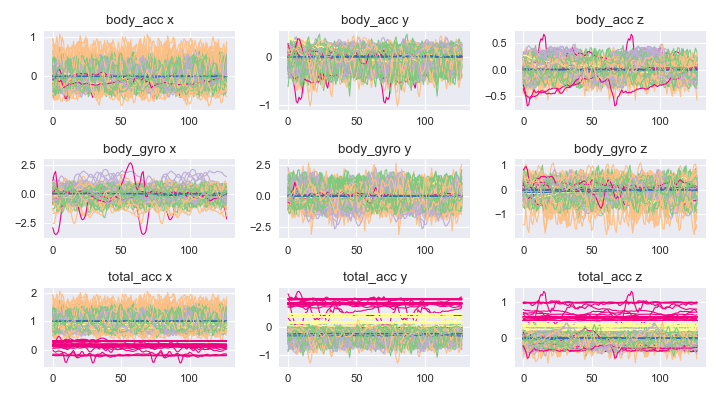

In [5]:
sample_to_plot = 50
index_per_act = [list(zip(np.repeat(act, sample_to_plot), np.where(Y_train_label==act)[0][:sample_to_plot])) for act in range(1,7)]
index_to_plot = list(itertools.chain.from_iterable(index_per_act))
random.shuffle(index_to_plot)

fig = plt.figure(figsize=(9,5))
for isignal in range(9):
    ax = fig.add_subplot(3,3,isignal+1)
    for act , i in index_to_plot:
        ax.plot(range(128), X_train[i,:,isignal],color=CMAP(act-1), linewidth=1)
        ax.set_title(SIGNALS[isignal])
plt.tight_layout()

### Par signaux 

<IPython.core.display.Javascript object>


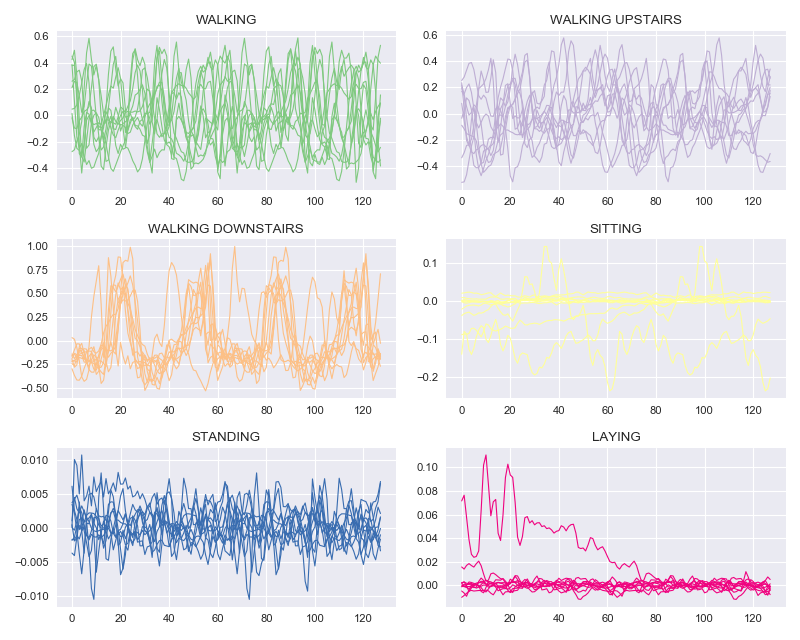

In [6]:
sample_to_plot = 10
isignal = 1
index_per_act_dict = dict([(act, np.where(Y_train_label==act)[0][:sample_to_plot]) for act in range(1,7)])


fig = plt.figure(figsize=(10,8), num=SIGNALS[isignal])
for act , index in index_per_act_dict.items():
    ax = fig.add_subplot(3,2,act)
    for x in X_train[index]:
        ax.plot(range(128), x[:,0],color=CMAP(act-1), linewidth=1)
    ax.set_title(ACTIVITY_DIC[act])
plt.tight_layout()

# Utils

In [7]:
DATA_DIR = "/Users/bguillouet/Insa/DeepLearning/data/HARWS/"

LABELS = ["WALKING","WALKING UPSTAIRS","WALKING DOWNSTAIRS","SITTING","STANDING","LAYING"]


ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


def my_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

def _count_classes(y):
    return len(set([tuple(category) for category in y]))



# Unidimensionel Times Series

Notre DataFrame d'apprentissage est de dimension (N_train, 1152)


## SVC
    * 1 minutes à l'apprentissage
    * Score très faible (56%)
A tester :
    * D'autres méthodes (Regression logistique, Xgboost?)
    * Choix dans les signaux (Seulement l'accéléromètre)?

In [8]:
t_start = time.time()
model_svc = ssvm.LinearSVC(verbose=1)
model_svc.fit(X_train_flatten, Y_train_label)
t_end = time.time()
t_learning = t_end-t_start
score = model_svc.score(X_test_flatten, Y_test_label)
print("Score With Linear SVC on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
svc_prediction_label = model_svc.predict(X_test_flatten)
metadata_svc = {"time_learning" : t_learning, "score" : score}
pd.DataFrame(confusion_matrix(svc_prediction_label, Y_test_label), index = LABELS, columns=LABELS)

[LibLinear]Score With Linear SVC on Inertial Signals = 57.55, Learning time = 64.10 secondes


/Users/bguillouet/anaconda/envs/DeepLearning/lib/python3.6/site-packages/sklearn/svm/base.py:920: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,WALKING,WALKING UPSTAIRS,WALKING DOWNSTAIRS,SITTING,STANDING,LAYING
WALKING,125,60,110,0,11,0
WALKING UPSTAIRS,82,226,61,25,94,27
WALKING DOWNSTAIRS,115,85,111,2,6,0
SITTING,86,35,63,426,123,0
STANDING,88,65,75,38,298,0
LAYING,0,0,0,0,0,510


## MLP

    * 30 secondes à l'apprentissage
    * Scores très largement amélioré (85%)
A tester :
    * Ajouter des couches
    * Différent paramètres (Dropout, activation function ...)
    * Choix dans les signaux (Seulement l'accéléromètre)?

In [9]:

epochs = 30
batch_size = 16
n_hidden = 32

n_features = X_train_flatten.shape[1]
n_classes=6


model_base_mlp_u =km.Sequential()
model_base_mlp_u.add(kl.Dense(n_hidden, input_shape=(n_features,),  activation = "relu"))
model_base_mlp_u.add(kl.Dropout(0.5))
model_base_mlp_u.add(kl.Dense(n_classes, activation='softmax'))
model_base_mlp_u.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_mlp_u.fit(X_train_flatten,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test_flatten, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp_u.evaluate(X_test_flatten, Y_test_dummies)[1] 
print("Score With Simple MLP on Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp_u = {"time_learning" : t_learning, "score" : score}
base_mlp_u_prediction = model_base_mlp_u.predict(X_test_flatten)

my_confusion_matrix(Y_test_dummies, base_mlp_u_prediction)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 1s - loss: 1.1281 - acc: 0.5397 - val_loss: 1.0248 - val_acc: 0.6770
Epoch 2/30
7352/7352 [==============================] - 0s - loss: 0.9146 - acc: 0.6491 - val_loss: 0.8870 - val_acc: 0.7139
Epoch 3/30
7352/7352 [==============================] - 0s - loss: 0.8145 - acc: 0.7004 - val_loss: 0.8266 - val_acc: 0.7604
Epoch 4/30
7352/7352 [==============================] - 0s - loss: 0.7339 - acc: 0.7305 - val_loss: 0.7564 - val_acc: 0.7710
Epoch 5/30
7352/7352 [==============================] - 0s - loss: 0.6982 - acc: 0.7459 - val_loss: 0.7738 - val_acc: 0.7961
Epoch 6/30
7352/7352 [==============================] - 0s - loss: 0.6509 - acc: 0.7612 - val_loss: 0.7038 - val_acc: 0.7991
Epoch 7/30
7352/7352 [==============================] - 0s - loss: 0.6313 - acc: 0.7663 - val_loss: 0.6905 - val_acc: 0.7964
Epoch 8/30
7352/7352 [==============================] - 0s - loss: 0.6104 - a

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,537,0,0,0,0,0
SITTING,0,308,158,1,1,23
STANDING,0,24,432,1,7,68
WALKING,0,3,2,408,40,43
WALKING_DOWNSTAIRS,0,7,2,48,325,38
WALKING_UPSTAIRS,0,3,0,60,40,368


In [10]:
model_base_mlp_u.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                36896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 37,094
Trainable params: 37,094
Non-trainable params: 0
_________________________________________________________________


# MultiDimensionel Time Series

## MLP

* Environ 80% Bien classé
* Meilleurs résultats sur lapprentissage, mais grande instabilité sur l'échantillon test
* 30 seconde de temps d'apprentissage

In [11]:
epochs = 30
batch_size = 16
n_hidden = 32


timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6



model_base_mlp =km.Sequential()
model_base_mlp.add(kl.Dense(n_hidden, input_shape=(timesteps, input_dim),  activation = "relu"))
model_base_mlp.add(kl.Reshape((timesteps*n_hidden,) , input_shape= (timesteps, n_hidden)  ))
model_base_mlp.add(kl.Dense(n_classes, activation='softmax'))

model_base_mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


t_start = time.time()
model_base_mlp.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp.evaluate(X_test, Y_test_dummies)[1] 
print("Score With Simple MLP on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp = {"time_learning" : t_learning, "score" : score}
base_mlp_prediction = model_base_mlp.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_mlp_prediction)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 1s - loss: 0.5882 - acc: 0.7461 - val_loss: 0.6827 - val_acc: 0.7672
Epoch 2/30
7352/7352 [==============================] - 1s - loss: 0.3764 - acc: 0.8490 - val_loss: 0.9285 - val_acc: 0.6916
Epoch 3/30
7352/7352 [==============================] - 1s - loss: 0.3277 - acc: 0.8731 - val_loss: 1.0333 - val_acc: 0.7275
Epoch 4/30
7352/7352 [==============================] - 1s - loss: 0.3050 - acc: 0.8815 - val_loss: 0.7749 - val_acc: 0.7947
Epoch 5/30
7352/7352 [==============================] - 1s - loss: 0.2977 - acc: 0.8896 - val_loss: 0.9818 - val_acc: 0.7448
Epoch 6/30
7352/7352 [==============================] - 1s - loss: 0.2943 - acc: 0.8935 - val_loss: 0.8803 - val_acc: 0.7954
Epoch 7/30
7352/7352 [==============================] - 1s - loss: 0.2831 - acc: 0.9042 - val_loss: 1.2344 - val_acc: 0.7126
Epoch 8/30
7352/7352 [==============================] - 1s - loss: 0.2931 - a

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,0,0,0,27
SITTING,0,226,241,0,0,24
STANDING,0,15,517,0,0,0
WALKING,0,0,44,378,65,9
WALKING_DOWNSTAIRS,0,0,6,27,381,6
WALKING_UPSTAIRS,0,0,47,56,30,338


In [12]:
model_base_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128, 32)           320       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24582     
Total params: 24,902
Trainable params: 24,902
Non-trainable params: 0
_________________________________________________________________


## LSTM

### Base LSTM

* Modèle sauvé arrive a 92%
* Tourne autour de 90* en général
* Résultats non reproduit malgré graine fixé
* Environ 25 minutes de temps d'apprentissage! 

A tester : 
* Différents paramètre /Couche
* Nombre de série temporelle a prendre en compte.

In [13]:
epochs = 30
batch_size = 16
n_hidden = 32


timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6


#else:
model_base_lstm =km.Sequential()
model_base_lstm.add(kl.LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model_base_lstm.add(kl.Dense(n_classes, activation='softmax'))

model_base_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_lstm.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_lstm.evaluate(X_test, Y_test_dummies)[1] 
print("Score With Simple MLP on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_lstm = {"time_learning" : t_learning, "score" : score}
base_lstm_prediction = model_base_lstm.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_lstm_prediction)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 50s - loss: 1.0852 - acc: 0.5469 - val_loss: 0.8892 - val_acc: 0.6525
Epoch 2/30
7352/7352 [==============================] - 47s - loss: 0.6594 - acc: 0.7390 - val_loss: 0.6291 - val_acc: 0.7703
Epoch 3/30
7352/7352 [==============================] - 45s - loss: 0.4636 - acc: 0.8379 - val_loss: 0.5330 - val_acc: 0.8368
Epoch 4/30
7352/7352 [==============================] - 45s - loss: 0.3098 - acc: 0.8988 - val_loss: 0.4539 - val_acc: 0.8724
Epoch 5/30
7352/7352 [==============================] - 45s - loss: 0.2502 - acc: 0.9124 - val_loss: 0.4805 - val_acc: 0.8609
Epoch 6/30
7352/7352 [==============================] - 45s - loss: 0.1916 - acc: 0.9293 - val_loss: 0.3626 - val_acc: 0.8890
Epoch 7/30
7352/7352 [==============================] - 45s - loss: 0.1679 - acc: 0.9391 - val_loss: 0.3235 - val_acc: 0.8979
Epoch 8/30
7352/7352 [==============================] - 45s - loss: 0.

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,0,0,0,27
SITTING,2,414,71,1,0,3
STANDING,0,97,428,4,1,2
WALKING,0,0,0,491,2,3
WALKING_DOWNSTAIRS,0,0,0,5,403,12
WALKING_UPSTAIRS,0,5,0,17,3,446


In [14]:
model_base_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_path = DATA_DIR+"keras_model/LSTM_dense.h5"
if os.path.isfile(model_path):
    model_base_lstm_92 = km.load_model(model_path)
    print(model_base_lstm_92.evaluate(X_test,Y_test_dummies))
    print(model_base_lstm_92.summary())

2944/2947 [============================>.] - ETA: 0s[0.49561213459482323, 0.92093654563963356]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
None


## Convolutional 

### 1D

* 1 minutes learning
* 92% avec une couche SIze 9 conv filteret Size 3 Pool Filter
* Descend très vite dès que je rajoute une couche

In [16]:
epochs = 30
batch_size = 16
n_hidden = 32


timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

#else:
model_base_conv_1D =km.Sequential()
model_base_conv_1D.add(kl.Conv1D(32, 9, activation='relu', input_shape=(timesteps, input_dim)))
model_base_conv_1D.add(kl.MaxPooling1D(pool_size=3))
#model_base_conv_1D.add(kl.Dropout(0.5))
#model_base_conv_1D.add(kl.Conv1D(32, 9, activation='relu'))
#model_base_conv_1D.add(kl.MaxPooling1D(pool_size=3))
model_base_conv_1D.add(kl.Flatten())
#model_base_conv_1D.add(Dense(32, activation='relu'))
#model_base_conv_1D.add(Dropout(0.5))
model_base_conv_1D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_1D.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_conv_1D.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_conv_1D.evaluate(X_test, Y_test_dummies)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_conv = {"time_learning" : t_learning, "score" : score}
base_conv_1D_prediction = model_base_conv_1D.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_conv_1D_prediction)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 2s - loss: 0.4434 - acc: 0.8286 - val_loss: 0.4235 - val_acc: 0.8839
Epoch 2/30
7352/7352 [==============================] - 2s - loss: 0.1746 - acc: 0.9376 - val_loss: 0.2986 - val_acc: 0.9189
Epoch 3/30
7352/7352 [==============================] - 2s - loss: 0.1434 - acc: 0.9452 - val_loss: 0.3389 - val_acc: 0.9179
Epoch 4/30
7352/7352 [==============================] - 2s - loss: 0.1428 - acc: 0.9448 - val_loss: 0.3569 - val_acc: 0.9050
Epoch 5/30
7352/7352 [==============================] - 2s - loss: 0.1426 - acc: 0.9441 - val_loss: 0.3850 - val_acc: 0.9128
Epoch 6/30
7352/7352 [==============================] - 2s - loss: 0.1594 - acc: 0.9431 - val_loss: 0.3305 - val_acc: 0.9294
Epoch 7/30
7352/7352 [==============================] - 2s - loss: 0.1683 - acc: 0.9442 - val_loss: 0.3350 - val_acc: 0.9237
Epoch 8/30
7352/7352 [==============================] - 2s - loss: 0.1961 - a

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,511,0,0,0,0,26
SITTING,0,324,157,0,1,9
STANDING,0,30,501,1,0,0
WALKING,0,0,0,479,17,0
WALKING_DOWNSTAIRS,0,0,1,0,399,20
WALKING_UPSTAIRS,0,0,0,5,25,441


In [17]:
model_base_conv_1D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 120, 32)           2624      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 7686      
Total params: 10,310
Trainable params: 10,310
Non-trainable params: 0
_________________________________________________________________


### 2D

* 1 minute pour converger
* Meilleur score pour une couche de convolution + 1 max pooling (Mais Haute variabilité)
* Ajouter des couches décroit sensiblement le score

In [18]:
epochs = 30
batch_size = 16
n_hidden = 32


timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

X_train_conv = X_train.reshape(N_train, timesteps, input_dim, 1)
X_test_conv = X_test.reshape(N_test, timesteps, input_dim, 1)

#else:
model_base_conv_2D =km.Sequential()
model_base_conv_2D.add(kl.Conv2D(32, (3, 9), activation='relu', input_shape=(timesteps, input_dim, 1)))
model_base_conv_2D.add(kl.MaxPooling2D(pool_size=(2, 1)))
#model_base_conv_2D.add(kl.Conv2D(32, (3, 3), activation='relu'))
#model_base_conv_2D.add(kl.MaxPooling2D(pool_size=(3, 9)))
model_base_conv_2D.add(kl.Flatten())
#model_base_conv_2D.add(Dense(32, activation='relu'))
#model_base_conv_2D.add(Dropout(0.5))
model_base_conv_2D.add(kl.Dense(n_classes, activation='softmax'))
model_base_conv_2D.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

t_start = time.time()
model_base_conv_2D.fit(X_train_conv,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test_conv, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_conv_2D.evaluate(X_test_conv, Y_test_dummies)[1] 
print("Score With Conv on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_conv = {"time_learning" : t_learning, "score" : score}
base_conv_2D_prediction = model_base_conv_2D.predict(X_test_conv)

my_confusion_matrix(Y_test_dummies, base_conv_2D_prediction)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 2s - loss: 0.5867 - acc: 0.7579 - val_loss: 0.6206 - val_acc: 0.7784
Epoch 2/30
7352/7352 [==============================] - 1s - loss: 0.3274 - acc: 0.8751 - val_loss: 0.6567 - val_acc: 0.7964
Epoch 3/30
7352/7352 [==============================] - 1s - loss: 0.2688 - acc: 0.8995 - val_loss: 0.4799 - val_acc: 0.8429
Epoch 4/30
7352/7352 [==============================] - 1s - loss: 0.2397 - acc: 0.9138 - val_loss: 0.4620 - val_acc: 0.8537
Epoch 5/30
7352/7352 [==============================] - 1s - loss: 0.2227 - acc: 0.9149 - val_loss: 0.6609 - val_acc: 0.8107
Epoch 6/30
7352/7352 [==============================] - 1s - loss: 0.2067 - acc: 0.9246 - val_loss: 1.3677 - val_acc: 0.6990
Epoch 7/30
7352/7352 [==============================] - 1s - loss: 0.2139 - acc: 0.9227 - val_loss: 0.4917 - val_acc: 0.8544
Epoch 8/30
7352/7352 [==============================] - 1s - loss: 0.2106 - a

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,0,0,0,27
SITTING,0,246,237,1,0,7
STANDING,0,17,514,1,0,0
WALKING,0,0,7,469,4,16
WALKING_DOWNSTAIRS,0,0,7,68,302,43
WALKING_UPSTAIRS,1,0,9,38,18,405


In [19]:
model_base_conv_2D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 1, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 1, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2016)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 12102     
Total params: 12,998
Trainable params: 12,998
Non-trainable params: 0
_________________________________________________________________
